In [1]:
import seaborn as sns
import metapack as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display 

%matplotlib inline
sns.set_context('notebook')
mp.jupyter.init()


# Imputing missing months

This notebook build a dataset that fills in the three missing months of data from the main dataset. 


In [2]:
pkg = mp.jupyter.open_package()
#pkg = mp.jupyter.open_source_package()
pkg

# Downtown San Diego Homeless Sleepers
`sandiegodata.org-dowtown_homeless-7` Last Update: 2019-10-02T04:01:38

_Five years of monthly geographic positions for homeless sleepers in Downtown San Diego_


**NOTE: This is an early version of the data, and there are still some noteable
discrepancies versus the official Downtown San Diego Partnership counts. This
data is suitable for some exploratory analysis, but not final results. Contact
eric@sandiegodata.org for more information**

This dataset provides geographic locations for homeless sleepers in Downtown San Diego, as counted by enumerators from the Downtown San Diego Partnership. These counts have been done monthly since 2012, and this dataset provides counts since 2014. 

<center><a href="https://data.sandiegodata.org/wp-content/uploads/sites/18/2019/10/Homeless-Sleepers.png"><img src="https://data.sandiegodata.org/wp-content/uploads/sites/18/2019/10/Homeless-Sleepers.png" width="400px"></a></center>


The count is done on paper maps with handwritten count marks. The San Diego
Regional Data Library's [Downton Homelessness
project](http://downtown-homelessness.sandiegodata.org/) converted these
scanned count maps using a [web based image annotation
tool](http://www.robots.ox.ac.uk/~vgg/software/via/).


## Caveats

Because this data is extracted, manually, from manually recorded maps, there
are a lot of quality issues. 

### Missing Months

Because of conversion errors and some complications with the source maps, there
are several months of data that are excluded from this dataset

* **August 2014**. In the original datasets, August 2014 was a duplicate of September 2014. 
* **September 2014**. Comfusion related to the duplication of September and August resulted in September being incompletely processed. 
* **June 2015**. All of the map images for this month were blank. An alternate source PDF exists that is not blank, but this file was not used.     


### Not Using Ocupancy Multipliers

Since about 2017, HUD has instructed point-in-time homeless counts to multiply
the counts of sleepers in structures and vehicles by factors to account for
people who may be obsured and not directly countable. From April 2017 on,
Downtown San Diego Partnership has been using these factors.

However, this dataset does not use the occupancy factors, to allow analysts to
apply these factors consistently across all months of data. As a result, the
counts from this dataset diverge from the official counts after March 2017.

### Other Issues 

* The ``total_count`` often does not match the sum of counts on the map. These sums were made by hand, by the enumerator who made the counts, so there are occasional arithmetic errors.  
* There are many instances of missing values for ``rain`` or ``temp``
* Some dates include the day of the month, but many don't These dates have a day of month of 1.
* Date day of month is generally unreliable. Only the year and month are reliable, except for files noted above. 
* The ``neighborhood`` value is based on the map names, so in some months
  the East Village neighborhood is separated into ``east_village`` and ``east_village_south``

### Comparison to Official Published Counts

This plot shows, per month, the offical published counts from San Diego Downtown Partnership versus the total from this dataset. Note the descrepancies dues to issues noted above, including missing months, minor differences in some months, and the divergence after March 2017 due to occupancy multiplers. 

<center><a href="https://data.sandiegodata.org/wp-content/uploads/sites/18/2019/10/homeless-new-vs-official.png"><img src="https://data.sandiegodata.org/wp-content/uploads/sites/18/2019/10/homeless-new-vs-official.png" width="700px"></a></center>

## Versions

1. Initial Version
2. Reload upstream source, with better datatypes
3. Add monthly and neighborhood totals
4. Updated to version 4 source package
5. Updates to version 5 of source package, which excluded several months with quality 

In [3]:
pkg.resource('homeless_counts')

Header,Type,Description
neighborhood,string,"Neighborhood, from the label on the source map"
date,date,"Date of the observation. Many dates have no know day of month; for these dates, the day of month is set to 1"
type,string,"Type of sleeper: individual, vehicle or structure"
temp,float,"Temperature, if it was written on the source map"
rain,string,"Rain or clear, if it was written on the source map"
geoid,string,"Census geoid for the 2010 Census block the observation is in, in ACS format"
x,number,"X geographic position, in California State Plane 6, EPSG:2230"
y,number,"Y geographic position, in California State Plane 6, EPSG:2230"
geometry,string,"Geographic position of observation, in Lat/Lon, EPSG:4326"


In [4]:
df = pkg.resource('homeless_counts').dataframe()
df['date'] = pd.to_datetime(df.date)
df['records'] = 1
df['month_start_date'] = df.date.apply(lambda v: pd.to_datetime(v.strftime('%Y-%m-01')))

In [5]:
from rowgenerators import dataframe
t = df.set_index('date')

t['imputed'] = False

t = t.groupby(pd.Grouper(freq="MS")).records.count().to_frame()
missing_records = t[t.records == 0].index
missing_records.sort_values()

missing_date = missing_records[0]
missing_date  - pd.offsets.MonthBegin(2)

mt = dataframe('../data/monthly_totals.csv#&encoding=ascii')
mt['date'] = pd.to_datetime(mt.date)
mt.set_index('date', inplace=True)


In [6]:
def sampled_counts(mr_index):
    """Select a suitable set of records to use as samples for selecting sleepings for
    a missing month, then select a number for each, proportional to the proportion of sleepers in that block. 
    The result is a set of new imputed records that matches the number of record in the official states and
    has the right portion of sleepers in each block. """
    
    import random
    
    # Find a range for selecting samples that is around the missing date and sifficiently large
    missing_date = missing_records[mr_index]

    t = df.set_index('month_start_date').sort_index()
    for i in range(10):
        min_date, max_date = missing_date  - pd.offsets.MonthBegin(i), missing_date  + pd.offsets.MonthBegin(i)

        # COllect at least 1,000 records for the sample set. 
        if len(t.loc[min_date:max_date]) > 1000:
            break

   
    t = t.loc[min_date: max_date].groupby('geoid').records.sum()
    block_prop = t / t.sum()  # proportion of sleepers in each block

    target_count = mt.loc[missing_records].iloc[mr_index]['count']

    sleepers_per_block = (block_prop * target_count).round() # Number of samples per census block
    
    actual_count = sleepers_per_block.sum()

    # +1 or -1, depending on wether the actual value is larger or smaller than target
    inc = int(abs(target_count - actual_count)) / int(target_count - actual_count)

    # Randomly select a number of rows to tweak equal to the diff between the target and actual
    # but only rows that have 5 or more sleepers,
    shuffled_index = list(sleepers_per_block.index)
    np.random.shuffle(shuffled_index)
   
    for idx in shuffled_index:
        if sleepers_per_block.loc[idx] + inc > 0: 
            sleepers_per_block.loc[idx] += inc
            
        actual_count = sleepers_per_block.sum()
        
        if actual_count == target_count:
            break
        
    assert sleepers_per_block.sum() == target_count, (len(t), inc, actual_count, target_count, sleepers_per_block.sum())
    
    # Now sleepers_per_block has the number of records we need to sample for each block. 
    
    rows = []
    
    for idx, row in sleepers_per_block.to_frame().iterrows():
        
        
        sample_index = np.random.choice(list(df[df.geoid==idx].index),int(row.records))
    
        
        for idx in sample_index:
            row = df.loc[idx].copy()
            row.rain = ''
            row.temp = np.nan
            row.date = missing_date
           
            rows.append(row)
            
    impute =  pd.DataFrame(rows)
    
    assert len(impute) == target_count
    
    return impute 
    
    
imputes = None

for e in range(len(missing_records)):

    t = sampled_counts(e)
    
    if imputes is None:
        imputes = t
    else:
        imputes = pd.concat([imputes, t])
   
imputes.head()

,neighborhood,date,type,temp,rain,geoid,x,y,geometry,records,month_start_date
18540,east_village,2014-08-01,individual,NaN,,10100US060730051001001,6.285069e+06,1.839559e+06,"POLYGON ((-117.148549 32.710455, -117.148728 3...",1,2014-11-01
18073,east_village,2014-08-01,individual,NaN,,10100US060730051001001,6.285196e+06,1.839665e+06,"POLYGON ((-117.148549 32.710455, -117.148728 3...",1,2016-02-01
18480,east_village,2014-08-01,individual,NaN,,10100US060730051001001,6.285094e+06,1.839569e+06,"POLYGON ((-117.148549 32.710455, -117.148728 3...",1,2015-11-01
18516,east_village,2014-08-01,individual,NaN,,10100US060730051001001,6.285205e+06,1.839587e+06,"POLYGON ((-117.148549 32.710455, -117.148728 3...",1,2017-10-01
18028,east_village,2014-08-01,individual,NaN,,10100US060730051001001,6.285058e+06,1.839703e+06,"POLYGON ((-117.148549 32.710455, -117.148728 3...",1,2016-09-01


In [7]:
imputes.head().T

,18540,18073,18480,18516,18028
neighborhood,east_village,east_village,east_village,east_village,east_village
date,2014-08-01 00:00:00,2014-08-01 00:00:00,2014-08-01 00:00:00,2014-08-01 00:00:00,2014-08-01 00:00:00
type,individual,individual,individual,individual,individual
temp,NaN,NaN,NaN,NaN,NaN
rain,,,,,
geoid,10100US060730051001001,10100US060730051001001,10100US060730051001001,10100US060730051001001,10100US060730051001001
x,6.28507e+06,6.2852e+06,6.28509e+06,6.28521e+06,6.28506e+06
y,1.83956e+06,1.83966e+06,1.83957e+06,1.83959e+06,1.8397e+06
geometry,"POLYGON ((-117.148549 32.710455, -117.148728 3...","POLYGON ((-117.148549 32.710455, -117.148728 3...","POLYGON ((-117.148549 32.710455, -117.148728 3...","POLYGON ((-117.148549 32.710455, -117.148728 3...","POLYGON ((-117.148549 32.710455, -117.148728 3..."
records,1,1,1,1,1


In [8]:
imputed = pd.concat([df, imputes]).sort_values('date').drop(columns=['records','month_start_date'])

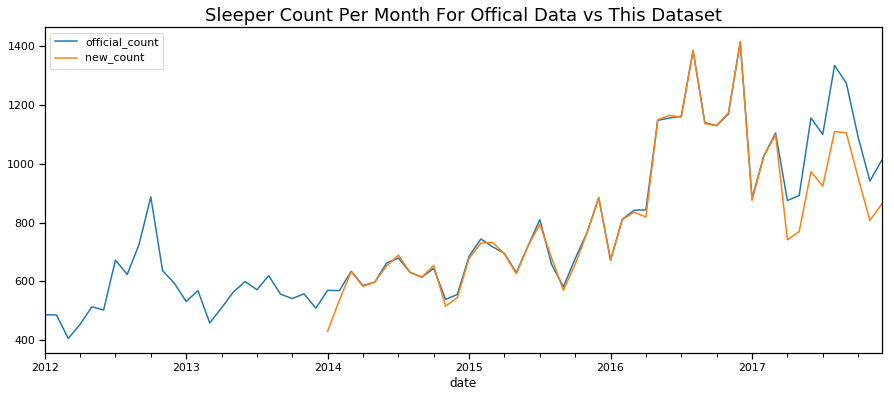

In [9]:
t = imputed.copy()

t['new_count'] = 1
t = t.set_index('date').groupby(pd.Grouper(freq="MS")).new_count.count().to_frame()
mt = pkg.resource('monthly_totals').dataframe().set_index('date').groupby(pd.Grouper(freq="MS")).sum().rename(columns={'count':'official_count'})

j = mt.join(t)
ax = j.plot(figsize=(15,6))
ax.set_title('Sleeper Count Per Month For Offical Data vs This Dataset', fontsize=18);

In [10]:
missing_records

DatetimeIndex(['2014-08-01', '2014-09-01', '2015-06-01'], dtype='datetime64[ns]', name='date', freq=None)